In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Read Data
import pickle
from google.colab import files
files.upload()
train_in = pickle.load(open('DS_5_train_input', 'rb')) 
train_out = pickle.load(open('DS_5_train_output', 'rb')) 
test_in = pickle.load(open('DS_5_test_input', 'rb'))

In [ ]:
# Histogram of words
import collections
def word_count_histogram(lst):
    word_counts = [len(s.split()) for s in lst]
    histogram = {}
    for count in word_counts:
        if count in histogram:
            histogram[count] += 1
        else:
            histogram[count] = 1
    sorted_histogram = {k: v for k, v in sorted(histogram.items(), key=lambda item: item[0])}
    return sorted_histogram
histogram = word_count_histogram(train_in)
print(histogram)
print('Train Inputs')
text = ' '.join(train_in)
counts = collections.Counter(text.split())
print("Counts:", counts)
print('Train Outputs')
text = ' '.join(train_out)
counts = collections.Counter(text.split())
print("Counts:", counts)
histogram = word_count_histogram(test_in)
print(histogram)
print('Test Inputs')
text = ' '.join(test_in)
counts = collections.Counter(text.split())
print("Counts:", counts)

{32: 631, 34: 563, 36: 457, 38: 437, 40: 389, 42: 359, 44: 309, 46: 292, 48: 240, 50: 237, 52: 213, 54: 196, 56: 147, 58: 172, 60: 122, 62: 116, 64: 120}
Train Inputs
Counts: Counter({'a': 48667, 'b': 29567, 'c': 29510, 'e': 23408, 'g': 21345, 'd': 21255, 'f': 21123, 'k': 6584, 'i': 4707, 'j': 4683, 'h': 4639})
Train Outputs
Counts: Counter({'a': 48667, 'b': 29567, 'c': 29510, 'e': 28408, 'g': 26345, 'd': 26255, 'f': 26123, 'k': 11584, 'i': 9707, 'j': 9683, 'h': 9639, 'l': 5000, 'm': 5000, 'ed': 5000, 'ee': 5000, 'ef': 5000, 'eg': 5000, 'eh': 5000, 'ei': 4369, 'ej': 3806, 'ek': 3349, 'el': 2912, 'em': 2523, 'fd': 2164, 'fe': 1855, 'ff': 1563, 'fg': 1323, 'fh': 1086, 'fi': 873, 'fj': 677, 'fk': 530, 'fl': 358, 'fm': 236, 'gd': 120})
{32: 634, 34: 560, 36: 497, 38: 420, 40: 416, 42: 355, 44: 331, 46: 272, 48: 254, 50: 239, 52: 198, 54: 155, 56: 172, 58: 138, 60: 134, 62: 116, 64: 109}
Test Inputs
Counts: Counter({'a': 48348, 'b': 29511, 'c': 29370, 'e': 23172, 'd': 21297, 'f': 21265, 'g'

Observations:  
*   k, i , j, h are less occuring
*   Train and test inputs look similar more or less
*   More or less balanced dataset 
*   Need to compare the same when test output is generated

In [ ]:
# Split into train, val and test
text_pairs = []
for i in range(len(train_in)):
    output = "[start] " + train_out[i] + " [end]"
    text_pairs.append((train_in[i], output))
random.shuffle(text_pairs)
num_val_samples = int(0.05 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

# prepare datasets
batch_size = 16
def format_dataset(input, output):
    input = source_vectorization(input)
    output = target_vectorization(output)
    return ({
        "input": input,
        "output": output[:, :-1],
    }, output[:, 1:])
def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

inputs['input'].shape: (16, 12)
inputs['output'].shape: (16, 36)
targets.shape: (16, 36)
16/16 [==============================] - 0s 2ms/step - loss: 0.2112 - accuracy: 0.0000e+00


Test acc: 0.000


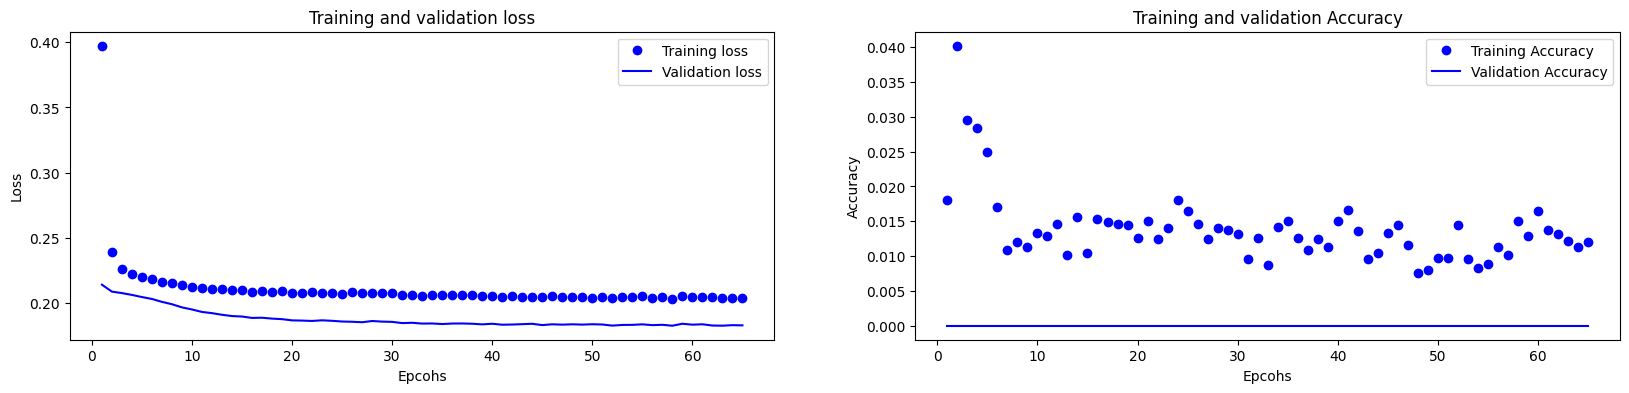

In [ ]:
# Binary 1-gram Model
# Vectorize integer sequences
source_vectorization = layers.TextVectorization(
    max_tokens=100,
    output_mode="multi_hot"
)
target_vectorization = layers.TextVectorization(
    max_tokens=100,
    output_mode="multi_hot"
)
train_input_texts = [pair[0] for pair in train_pairs]
train_output_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_input_texts)
target_vectorization.adapt(train_output_texts)
# Make Datasets
binary_1gram_train_ds = make_dataset(train_pairs)
binary_1gram_val_ds = make_dataset(val_pairs)
binary_1gram_test_ds = make_dataset(test_pairs)
for inputs, targets in binary_1gram_train_ds.take(1):
    print(f"inputs['input'].shape: {inputs['input'].shape}")
    print(f"inputs['output'].shape: {inputs['output'].shape}")
    print(f"targets.shape: {targets.shape}")
# Build Model
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(12,),  name="input")
x = layers.Dense(16, activation="relu")(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(36, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_1gram.keras",
              monitor="val_loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", 
              mode="min", 
              patience=7)
]
history = model.fit(binary_1gram_train_ds.cache(),
          validation_data=binary_1gram_val_ds.cache(),
          epochs=100, verbose=0, use_multiprocessing=True,
          callbacks=callbacks)
model = keras.models.load_model("binary_1gram.keras")
print(f"Test acc: {model.evaluate(binary_1gram_test_ds)[1]:.3f}")
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.legend(loc=2, fontsize=3)
plt.rcParams["figure.figsize"] = (20,4)
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
ax1.plot(epochs, loss_values, "bo", label="Training loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set(xlabel='Epcohs', ylabel='Loss')
ax1.legend()
ax2.plot(epochs, acc, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax2.set_title("Training and validation Accuracy")
ax2.set(xlabel='Epcohs', ylabel='Accuracy')
ax2.legend()
plt.show();

Observations: Model is not training at all. And also since we are discarding word order, let's try 2-gram

inputs['input'].shape: (16, 52)
inputs['output'].shape: (16, 99)
targets.shape: (16, 99)


/usr/local/lib/python3.9/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['output'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


16/16 [==============================] - 0s 2ms/step - loss: 0.4027 - accuracy: 0.0240


Test acc: 0.024


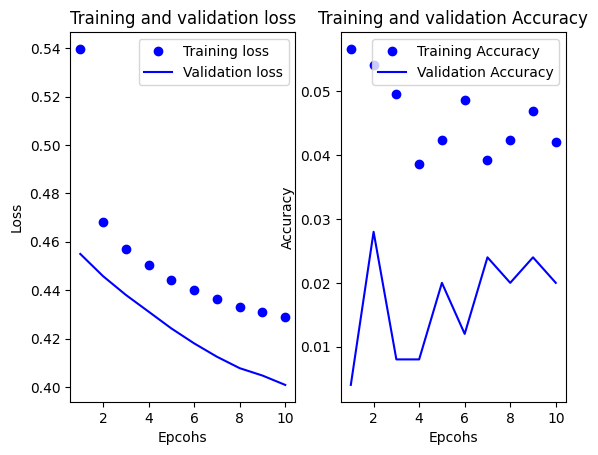

In [ ]:
# Binary 2-gram
source_vectorization = layers.TextVectorization(
    max_tokens=100,
    ngrams=2,
    output_mode="multi_hot"
)
target_vectorization = layers.TextVectorization(
    max_tokens=100,
    ngrams=2,
    output_mode="multi_hot"
)
train_input_texts = [pair[0] for pair in train_pairs]
train_output_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_input_texts)
target_vectorization.adapt(train_output_texts)
# prepare datasets
binary_2gram_train_ds = make_dataset(train_pairs)
binary_2gram_val_ds = make_dataset(val_pairs)
binary_2gram_test_ds = make_dataset(test_pairs)
for inputs, targets in binary_2gram_train_ds.take(1):
    print(f"inputs['input'].shape: {inputs['input'].shape}")
    print(f"inputs['output'].shape: {inputs['output'].shape}")
    print(f"targets.shape: {targets.shape}")

from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(52,),  name="input")
x = layers.Dense(16, activation="relu")(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(99, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_2gram.keras",
              monitor="val_loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", 
              mode="min", 
              patience=7)
]
history = model.fit(binary_2gram_train_ds.cache(),
          validation_data=binary_2gram_val_ds.cache(),
          epochs=10, verbose=0, use_multiprocessing=True,
          callbacks=callbacks)
model = keras.models.load_model("binary_2gram.keras")
print(f"Test acc: {model.evaluate(binary_2gram_test_ds)[1]:.3f}")
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.legend(loc=2, fontsize=3)
plt.rcParams["figure.figsize"] = (20,4)
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
ax1.plot(epochs, loss_values, "bo", label="Training loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set(xlabel='Epcohs', ylabel='Loss')
ax1.legend()
ax2.plot(epochs, acc, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax2.set_title("Training and validation Accuracy")
ax2.set(xlabel='Epcohs', ylabel='Accuracy')
ax2.legend()
plt.show();

Observations: Model atleast started training but not generalizing very well

inputs['input'].shape: (16, 52)
inputs['output'].shape: (16, 99)
targets.shape: (16, 99)
16/16 [==============================] - 0s 2ms/step - loss: -2051596.2500 - accuracy: 0.8520


Test acc: 0.852


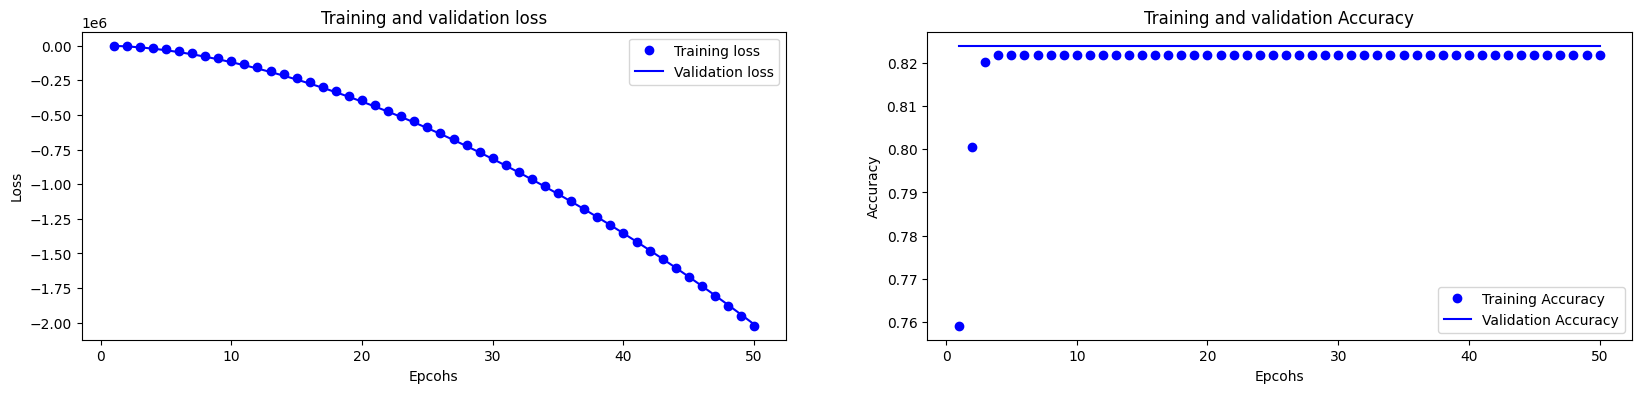

In [ ]:
# Bi-grams with tf-idf encoding 
source_vectorization = layers.TextVectorization(
    max_tokens=100,
    ngrams=2,
    output_mode="tf_idf"
)
target_vectorization = layers.TextVectorization(
    max_tokens=100,
    ngrams=2,
    output_mode="tf_idf"
)
train_input_texts = [pair[0] for pair in train_pairs]
train_output_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_input_texts)
target_vectorization.adapt(train_output_texts)
# prepare datasets
tfidf_2gram_train_ds = make_dataset(train_pairs)
tfidf_2gram_val_ds = make_dataset(val_pairs)
tfidf_2gram_test_ds = make_dataset(test_pairs)
for inputs, targets in tfidf_2gram_train_ds.take(1):
    print(f"inputs['input'].shape: {inputs['input'].shape}")
    print(f"inputs['output'].shape: {inputs['output'].shape}")
    print(f"targets.shape: {targets.shape}")

from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(52,),  name="input")
x = layers.Dense(512, activation="relu")(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(99, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint("tfidf_2gram.keras",
              monitor="val_loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", 
              mode="min", 
              patience=3)
]
history = model.fit(tfidf_2gram_train_ds.cache(),
          validation_data=tfidf_2gram_val_ds.cache(),
          epochs=50, verbose=0, use_multiprocessing=True,
          callbacks=callbacks)
model = keras.models.load_model("tfidf_2gram.keras")
print(f"Test acc: {model.evaluate(tfidf_2gram_test_ds)[1]:.3f}")
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.legend(loc=2, fontsize=3)
plt.rcParams["figure.figsize"] = (20,4)
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
ax1.plot(epochs, loss_values, "bo", label="Training loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set(xlabel='Epcohs', ylabel='Loss')
ax1.legend()
ax2.plot(epochs, acc, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax2.set_title("Training and validation Accuracy")
ax2.set(xlabel='Epcohs', ylabel='Accuracy')
ax2.legend()
plt.show();

Observations: Model accuracy definitely improved but we are getting negative loss and Val_accuracy seems to be at 82% from start - Let's see how accurately model is predicting sequences for test_data

In [ ]:
# Evaluate Model
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 100
model = keras.models.load_model("tfidf_2gram.keras")

def decode_sequence(model, input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    print(input_sentence)
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])[:, :-1]
        predictions = model.predict({'input':tokenized_input_sentence, 'output':tokenized_target_sentence}, verbose=0)
        sampled_token_index = np.argmax(predictions[0,:])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "end":
            break
    return decoded_sentence.strip('[start] ').strip(' [end')

def accuracy_for_words(model):
    cal_accuracy = []
    for pair in test_pairs[0:2]:
        predicted_words = decode_sequence(model, pair[0]).strip('[start] ').strip(' [end').split()
        ground_truth_words = pair[1].strip('[start] ').strip(' [end').split()
        num_words = len(ground_truth_words)
        accuracy = 0
        for i in range(min(len(predicted_words), len(ground_truth_words))):
            if predicted_words[i] == ground_truth_words[i]:
                accuracy += 1
            accuracy /= num_words
            cal_accuracy.append(accuracy)
    print(predicted_words)
    print(ground_truth_words)
    cal_accuracy = sum(cal_accuracy) / len(cal_accuracy)
    return cal_accuracy
print(accuracy_for_words(model))

/usr/local/lib/python3.9/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['output'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


['UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK']
['c', 'e', 'b', 'e', 'b', 'g', 'a', 'j', 'd', 'e', 'f', 'b', 'f', 'a', 'g', 'g', 'h', 'b', 'e', 'a', 

Observations:
* Tf-Idf Model is just predicting unknowns for all cases - May be model didnt really generalize very well
* Sequence information is not being taken into account by Binary-1gram, Binary-2gram and TF-IDF Models
* Let's try Sequence Models now

inputs['input'].shape: (16, 100)
inputs['output'].shape: (16, 100)
targets.shape: (16, 100)
16/16 [==============================] - 1s 11ms/step - loss: 1.4584 - accuracy: 0.5095
Test acc: 0.510


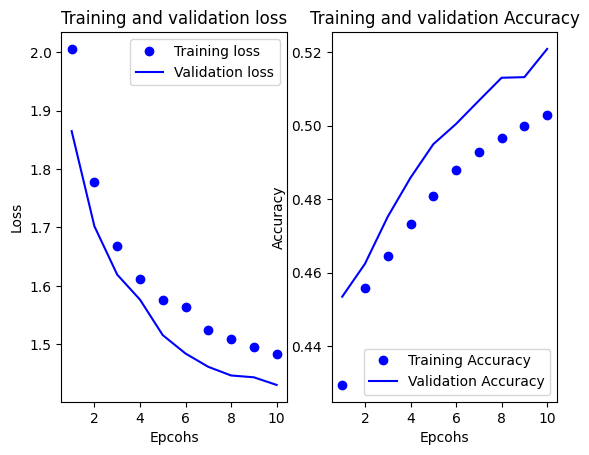

In [ ]:
# Sequence Model - One-Hot Bigram Model
source_vectorization = layers.TextVectorization(
    max_tokens=100,
    output_sequence_length=100,
    output_mode="int"
)
target_vectorization = layers.TextVectorization(
    max_tokens=100,
    output_sequence_length=101,
    output_mode="int"
)
train_input_texts = [pair[0] for pair in train_pairs]
train_output_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_input_texts)
target_vectorization.adapt(train_output_texts)
# prepare datasets
int_train_ds = make_dataset(train_pairs)
int_val_ds = make_dataset(val_pairs)
int_test_ds = make_dataset(test_pairs)
for inputs, targets in int_train_ds.take(1):
    print(f"inputs['input'].shape: {inputs['input'].shape}")
    print(f"inputs['output'].shape: {inputs['output'].shape}")
    print(f"targets.shape: {targets.shape}")

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

inputs = keras.Input(shape=(None,), dtype="int64", name="input")
embedded = tf.one_hot(inputs, depth=100)
x = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(100, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
              monitor="val_loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", 
              mode="min", 
              patience=5)
]
history = model.fit(int_train_ds.cache(),
          validation_data=int_val_ds.cache(),
          epochs=10, verbose=0, use_multiprocessing=True,
          callbacks=callbacks)
model = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.legend(loc=2, fontsize=3)
plt.rcParams["figure.figsize"] = (20,4)
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
ax1.plot(epochs, loss_values, "bo", label="Training loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set(xlabel='Epcohs', ylabel='Loss')
ax1.legend()
ax2.plot(epochs, acc, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax2.set_title("Training and validation Accuracy")
ax2.set(xlabel='Epcohs', ylabel='Accuracy')
ax2.legend()
plt.show();

In [ ]:
# Evaluate Model
def decode_sequence(model, target_vectorization, input_sentence):
    spa_vocab = target_vectorization.get_vocabulary()
    spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
    max_decoded_sentence_length = 100
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])[:, :-1]
        predictions = model.predict({'input':tokenized_input_sentence, 'output':tokenized_target_sentence}, verbose=0)
        sampled_token_index = np.argmax(predictions[0,i,:])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "end":
            break
    return decoded_sentence

import nltk

def compute_bleu(reference, candidate):
    return nltk.translate.bleu_score.sentence_bleu([reference], candidate)

def accuracy_for_words(model, target_vectorization):
    cal_accuracy = []
    bleu_score = []
    for pair in test_pairs[0:10]:
        predicted_words = decode_sequence(model, target_vectorization, pair[0]).strip('[start] ').strip(' [end').split()
        ground_truth_words = pair[1].strip('[start] ').strip(' [end').split()
        num_words = len(ground_truth_words)
        accuracy = 0
        for i in range(min(len(predicted_words), len(ground_truth_words))):
            if predicted_words[i] == ground_truth_words[i]:
                accuracy += 1
        accuracy /= num_words
        cal_accuracy.append(accuracy)
        bleu_score.append(compute_bleu(ground_truth_words, predicted_words))
    cal_accuracy = sum(cal_accuracy) / len(cal_accuracy)
    bleu_score = sum(bleu_score) / len(bleu_score)
    return cal_accuracy, bleu_score
model = keras.models.load_model("one_hot_bidir_lstm.keras")
print(accuracy_for_words(model, target_vectorization))

(0.24191250168740383, 0.0713310683071058)


Observations: Model accuracy increased and it's now trying to predict words. Let's try to overfit our model by adding more layers and see how it performs

inputs['input'].shape: (16, 100)
inputs['output'].shape: (16, 100)
targets.shape: (16, 100)
16/16 [==============================] - 3s 46ms/step - loss: 0.8511 - accuracy: 0.6757
Test acc: 0.676


(0.5060136936496454, 0.2814240162637917)


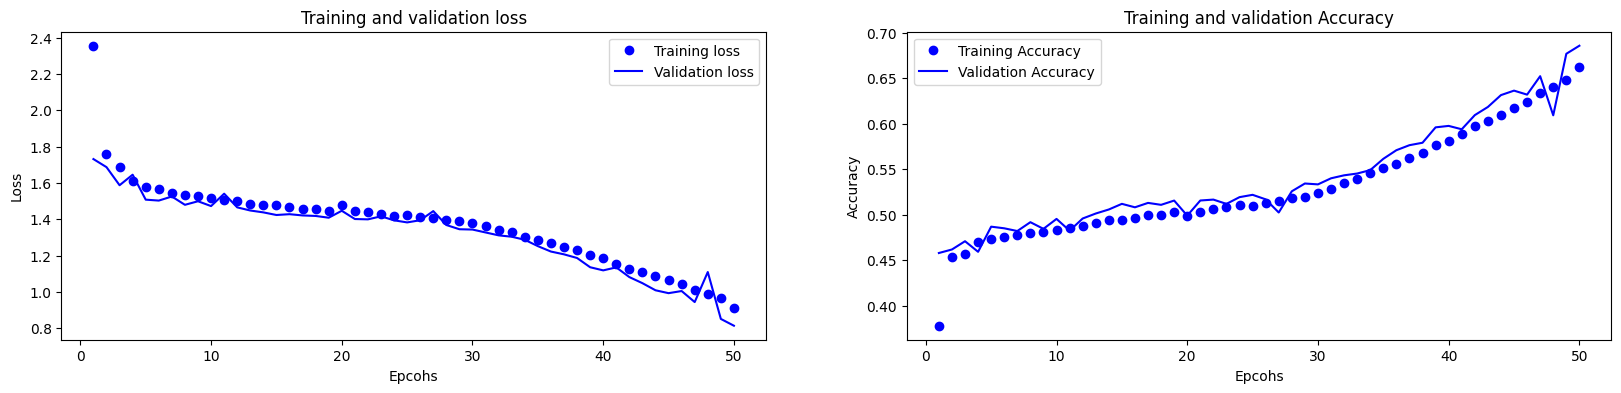

In [ ]:
# Sequence Model - One-Hot Bigram Model - 2nd try
source_vectorization = layers.TextVectorization(
    max_tokens=100,
    output_sequence_length=100,
    output_mode="int"
)
target_vectorization = layers.TextVectorization(
    max_tokens=100,
    output_sequence_length=101,
    output_mode="int"
)
train_input_texts = [pair[0] for pair in train_pairs]
train_output_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_input_texts)
target_vectorization.adapt(train_output_texts)
# prepare datasets
int_train_ds = make_dataset(train_pairs)
int_val_ds = make_dataset(val_pairs)
int_test_ds = make_dataset(test_pairs)
for inputs, targets in int_train_ds.take(1):
    print(f"inputs['input'].shape: {inputs['input'].shape}")
    print(f"inputs['output'].shape: {inputs['output'].shape}")
    print(f"targets.shape: {targets.shape}")

from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(None,), dtype="int64", name="input")
embedded = tf.one_hot(inputs, depth=100)
x = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(embedded)
x = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(100, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
              monitor="val_loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", 
              mode="min", 
              patience=5)
]
history = model.fit(int_train_ds.cache(),
          validation_data=int_val_ds.cache(),
          epochs=50, verbose=0, use_multiprocessing=True,
          callbacks=callbacks)
model = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")
model = keras.models.load_model("one_hot_bidir_lstm.keras")
print(accuracy_for_words(model, target_vectorization))
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.legend(loc=2, fontsize=3)
plt.rcParams["figure.figsize"] = (20,4)
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
ax1.plot(epochs, loss_values, "bo", label="Training loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set(xlabel='Epcohs', ylabel='Loss')
ax1.legend()
ax2.plot(epochs, acc, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax2.set_title("Training and validation Accuracy")
ax2.set(xlabel='Epcohs', ylabel='Accuracy')
ax2.legend()
plt.show();

Observations: Though it trains very slowly, Model accuracy improved and also 50.6% matching with output pairs. Let's add more layers, dropout and dense layer to see if it helps in improving model accuracy more

inputs['input'].shape: (16, 100)
inputs['output'].shape: (16, 100)
targets.shape: (16, 100)
16/16 [==============================] - 3s 44ms/step - loss: 0.2807 - accuracy: 0.9082
Test acc: 0.908


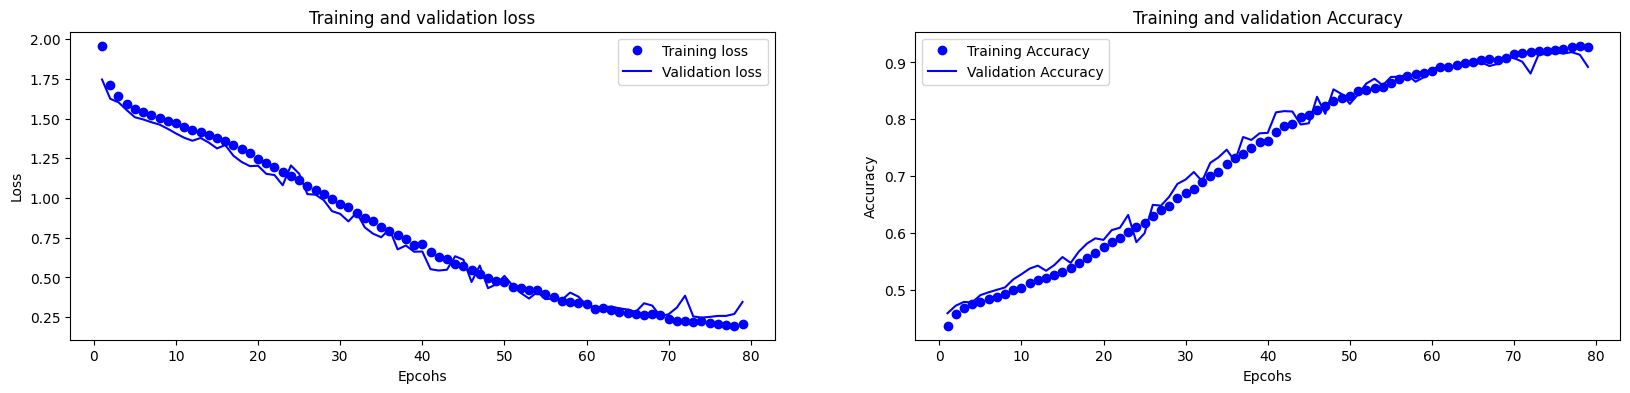

In [ ]:
# Sequence Model - One-Hot Bigram Model - Adding More Layers and Dropout
inputs = keras.Input(shape=(None,), dtype="int64", name="input")
embedded = tf.one_hot(inputs, depth=100)
x = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(embedded)
x = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(x)
x = layers.Dropout(0.5)(x)
x = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(100, activation="relu")(x)
outputs = layers.Dense(100, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
              monitor="val_loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", 
              mode="min", 
              patience=5)
]
history = model.fit(int_train_ds.cache(),
          validation_data=int_val_ds.cache(),
          epochs=100, verbose=0, use_multiprocessing=True,
          callbacks=callbacks)
model = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")
model = keras.models.load_model("one_hot_bidir_lstm.keras")
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.legend(loc=2, fontsize=3)
plt.rcParams["figure.figsize"] = (20,4)
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
ax1.plot(epochs, loss_values, "bo", label="Training loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set(xlabel='Epcohs', ylabel='Loss')
ax1.legend()
ax2.plot(epochs, acc, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax2.set_title("Training and validation Accuracy")
ax2.set(xlabel='Epcohs', ylabel='Accuracy')
ax2.legend()
plt.show();

In [ ]:
print(accuracy_for_words(model, target_vectorization))

(0.8989481035357038, 0.8227239285280282)


Observations: 
* Though it trains very slowly, Model accuracy improved and also 89.9% matching with output pairs
* Overfitting started about around 70 epochs unlike 40 in earlier case - adding dropout definitely helped
* Also since one-hot encoding performed well, we can make a deduction that different tokens we are encoding are more or less independent from each other
* Let's see how others compare now

16/16 [==============================] - 2s 42ms/step - loss: 0.6157 - accuracy: 0.7357
Test acc: 0.736


(0.6109607763029137, 0.4124179851402869)


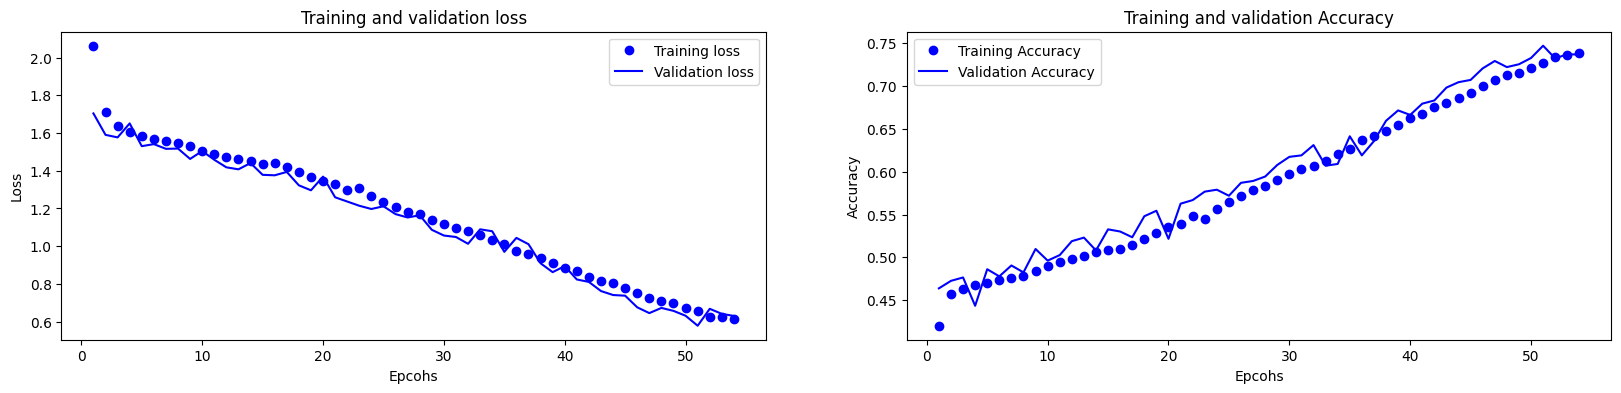

In [ ]:
# Embedding layer Model
inputs = keras.Input(shape=(None,), dtype="int64", name="input")
embedded = layers.Embedding(input_dim=100, output_dim=50)(inputs)
x = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(embedded)
x = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(x)
x = layers.Dropout(0.5)(x)
x = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(100, activation="relu")(x)
outputs = layers.Dense(100, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",
              monitor="val_loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", 
              mode="min", 
              patience=3)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=100, verbose=0, use_multiprocessing=True, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")
print(accuracy_for_words(model, target_vectorization))
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.legend(loc=2, fontsize=3)
plt.rcParams["figure.figsize"] = (20,4)
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
ax1.plot(epochs, loss_values, "bo", label="Training loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set(xlabel='Epcohs', ylabel='Loss')
ax1.legend()
ax2.plot(epochs, acc, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax2.set_title("Training and validation Accuracy")
ax2.set(xlabel='Epcohs', ylabel='Accuracy')
ax2.legend()
plt.show();

Observations: Model seems to be training well but Model accuracy and word accuracy are lower than that off one-hot bi-gram

16/16 [==============================] - 7s 31ms/step - loss: 0.5849 - accuracy: 0.8069
Test acc: 0.807


(0.5642446694938874, 0.46745781814626036)


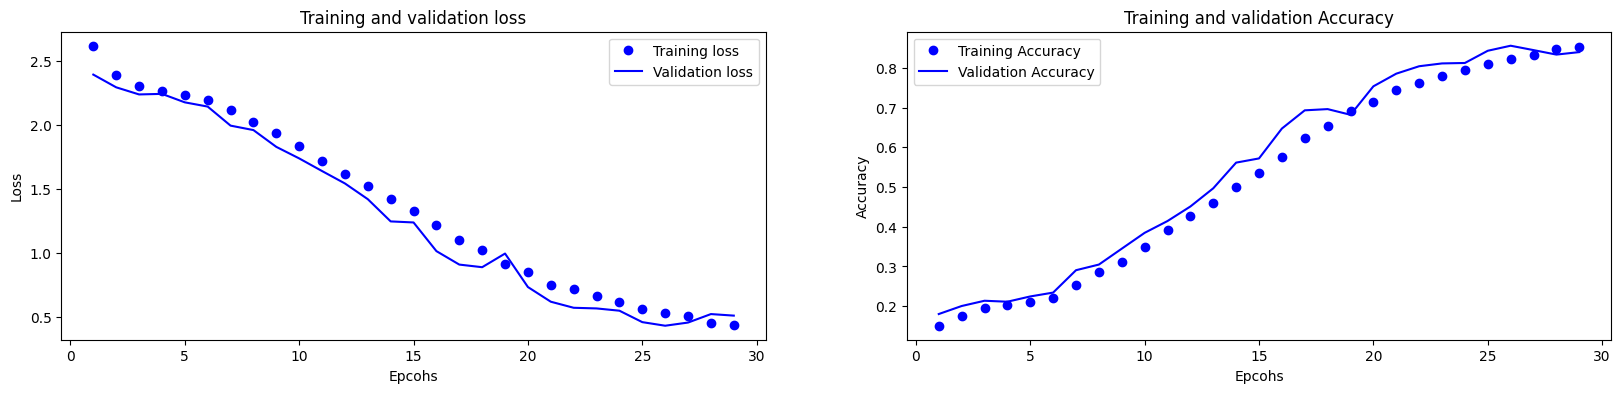

In [ ]:
# Embedding layer with masking enabled Model
inputs = keras.Input(shape=(None,), dtype="int64", name="input")
embedded = layers.Embedding(
    input_dim=100, output_dim=64, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(embedded)
x = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(x)
x = layers.Dropout(0.5)(x)
x = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(100, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
              monitor="val_loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", 
              mode="min", 
              patience=3)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=100, verbose=0, use_multiprocessing=True, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")
print(accuracy_for_words(model, target_vectorization))
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.legend(loc=2, fontsize=3)
plt.rcParams["figure.figsize"] = (20,4)
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
ax1.plot(epochs, loss_values, "bo", label="Training loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set(xlabel='Epcohs', ylabel='Loss')
ax1.legend()
ax2.plot(epochs, acc, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax2.set_title("Training and validation Accuracy")
ax2.set(xlabel='Epcohs', ylabel='Accuracy')
ax2.legend()
plt.show();

Observations: Better than one with earlier model which doesn't use masking but Model accuracy and word accuracy are lower than that off one-hot bi-gram

--2023-04-07 21:26:06--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-04-07 21:26:07--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-07 21:26:07--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

(0.45734788136477655, 0.26546313966373514)


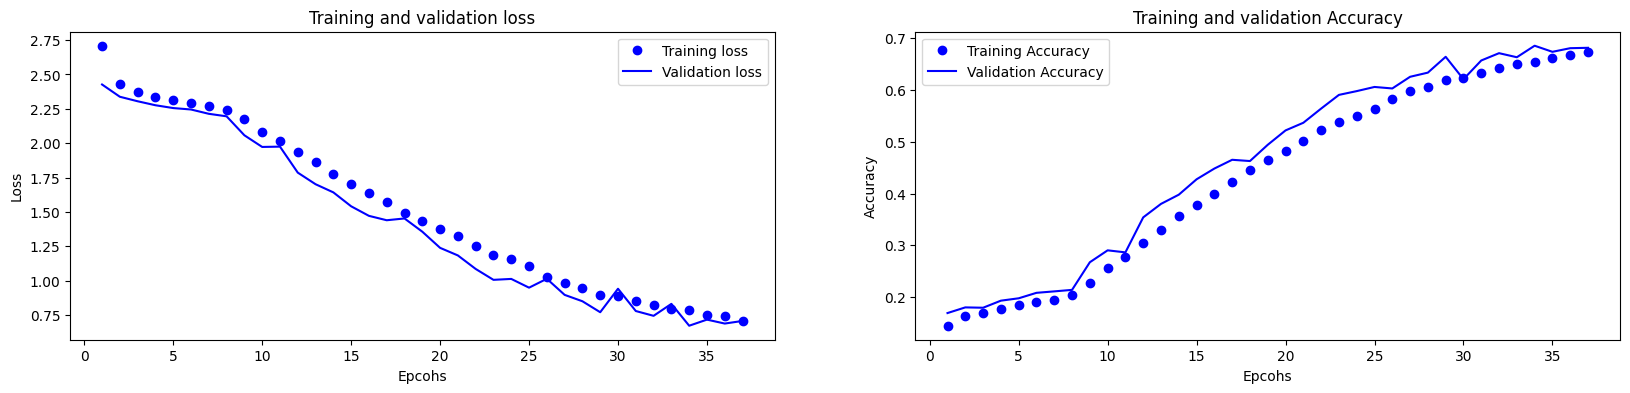

In [ ]:
# Pre-trained embedding Model
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip
import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

embedding_dim = 100

vocabulary = source_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((100, embedding_dim))
for word, i in word_index.items():
    if i < 100:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = layers.Embedding(
    100,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

inputs = keras.Input(shape=(None,), dtype="int64", name="input")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(embedded)
x = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(x)
x = layers.Dropout(0.5)(x)
x = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(100, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(100, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
              monitor="val_loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", 
              mode="min", 
              patience=3)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=100, verbose=0, use_multiprocessing=True, callbacks=callbacks)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")
print(accuracy_for_words(model, target_vectorization))
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.legend(loc=2, fontsize=3)
plt.rcParams["figure.figsize"] = (20,4)
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
ax1.plot(epochs, loss_values, "bo", label="Training loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set(xlabel='Epcohs', ylabel='Loss')
ax1.legend()
ax2.plot(epochs, acc, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax2.set_title("Training and validation Accuracy")
ax2.set(xlabel='Epcohs', ylabel='Accuracy')
ax2.legend()
plt.show();

Observations: Worse than one with earlier model and also Model accuracy and word accuracy are lower than that off one-hot bi-gram

16/16 [==============================] - 6s 26ms/step - loss: 0.8694 - accuracy: 0.5856
Test acc: 0.586


(0.13445537059387597, 0.07740716270133122)


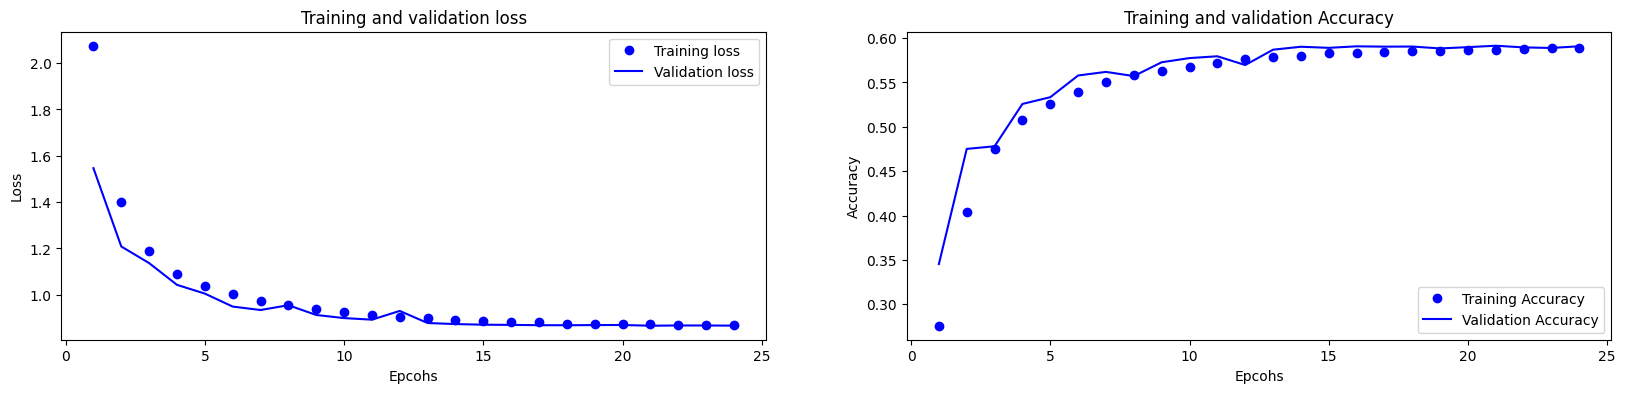

In [ ]:
# GRU Based Encoder
from tensorflow import keras
from tensorflow.keras import layers

embed_dim = 256
latent_dim = 512

source = keras.Input(shape=(None,), dtype="int64", name="input")
x = layers.Embedding(100, embed_dim, mask_zero=True)(source)
x = layers.Bidirectional(layers.GRU(latent_dim, return_sequences=True), merge_mode="sum")(x)
x = layers.Dropout(0.5)(x)
encoded_source = layers.Bidirectional(layers.GRU(latent_dim), merge_mode="sum")(x)
past_target = keras.Input(shape=(None,), dtype="int64", name="output")
x = layers.Embedding(100, embed_dim, mask_zero=True)(past_target)
decoder_gru = layers.GRU(latent_dim, return_sequences=True)
x = decoder_gru(x, initial_state=encoded_source)
x = layers.Dropout(0.5)(x)
x = layers.Dense(100, activation="relu")(x)
target_next_step = layers.Dense(100, activation="softmax")(x)
seq2seq_rnn = keras.Model([source, past_target], target_next_step)
seq2seq_rnn.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint("gru_encoder.keras",
              monitor="val_loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", 
              mode="min", 
              patience=3)
]
history = seq2seq_rnn.fit(int_train_ds, epochs=100, validation_data=int_val_ds, verbose=0, use_multiprocessing=True, callbacks=callbacks)
model = keras.models.load_model("gru_encoder.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")
print(accuracy_for_words(model, target_vectorization))
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.legend(loc=2, fontsize=3)
plt.rcParams["figure.figsize"] = (20,4)
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
ax1.plot(epochs, loss_values, "bo", label="Training loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set(xlabel='Epcohs', ylabel='Loss')
ax1.legend()
ax2.plot(epochs, acc, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax2.set_title("Training and validation Accuracy")
ax2.set(xlabel='Epcohs', ylabel='Accuracy')
ax2.legend()
plt.show();

Observations: 
* Model and word accuracy lower than one-hot bigram 
* Model predicts next words in the sequence accurately only 58% of the time
* Next token accuracy isn't a great metric since it assumes it's before tokens are correct
* Let's move onto transformers

16/16 [==============================] - 2s 23ms/step - loss: 0.1523 - accuracy: 0.9497
Test acc: 0.950


(0.7295435043277421, 0.784469245780073)


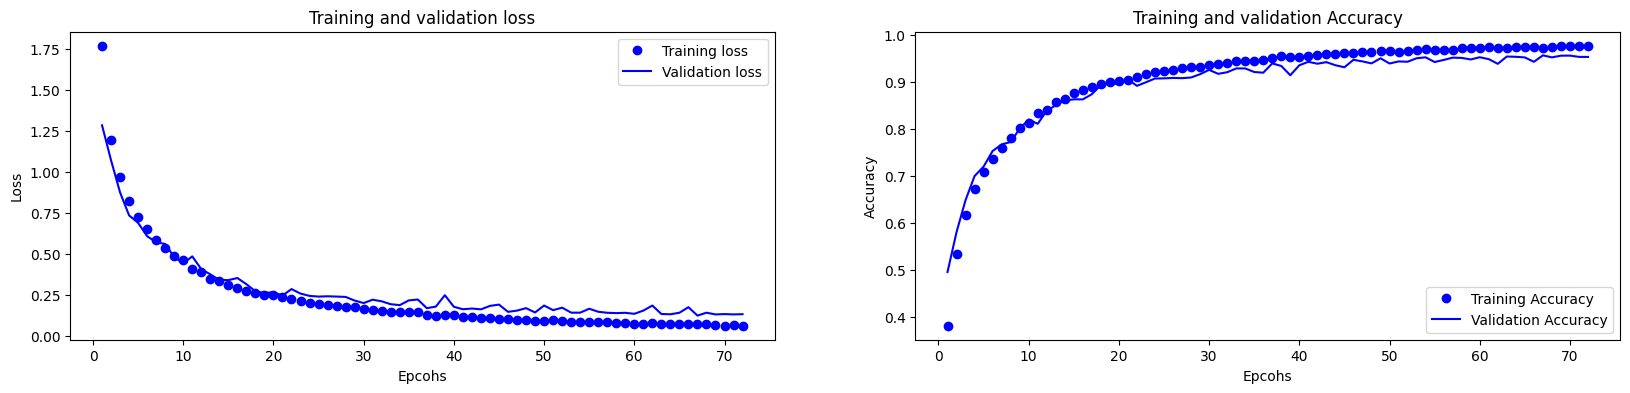

In [ ]:
# Transformer Encoder
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        proj_output = self.dense_proj(proj_output)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

# Transformer Decoder
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        proj_output = self.dense_proj(proj_output)
        return self.layernorm_3(attention_output_2 + proj_output)

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

embed_dim = 256
dense_dim = 512
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="input")
x = PositionalEmbedding(100, 100, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="output")
x = PositionalEmbedding(100, 100, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(100, activation="softmax")(x)
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
transformer.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint("transformer.keras",
              monitor="val_loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", 
              mode="min", 
              patience=5)
]
history = transformer.fit(int_train_ds, epochs=100, validation_data=int_val_ds, verbose=0, use_multiprocessing=True, callbacks=callbacks)
model = keras.models.load_model(
    "transformer.keras",
    custom_objects={"TransformerDecoder": TransformerDecoder,
                    "TransformerEncoder": TransformerEncoder,
                    "PositionalEmbedding": PositionalEmbedding})
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")
print(accuracy_for_words(model, target_vectorization))
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.legend(loc=2, fontsize=3)
plt.rcParams["figure.figsize"] = (20,4)
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
ax1.plot(epochs, loss_values, "bo", label="Training loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set(xlabel='Epcohs', ylabel='Loss')
ax1.legend()
ax2.plot(epochs, acc, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax2.set_title("Training and validation Accuracy")
ax2.set(xlabel='Epcohs', ylabel='Accuracy')
ax2.legend()
plt.show();

Observations: Though Transformer gave us highest accuracy, it's word accuracy is lower compared to one-hot bi-gram model. Let's try adding dropout and an extra dense layer as we did with one-hot to see if it'll improve the word accuracy

16/16 [==============================] - 1s 17ms/step - loss: 0.1302 - accuracy: 0.9524
Test acc: 0.952


(0.6420688409324586, 0.7106799945311633)


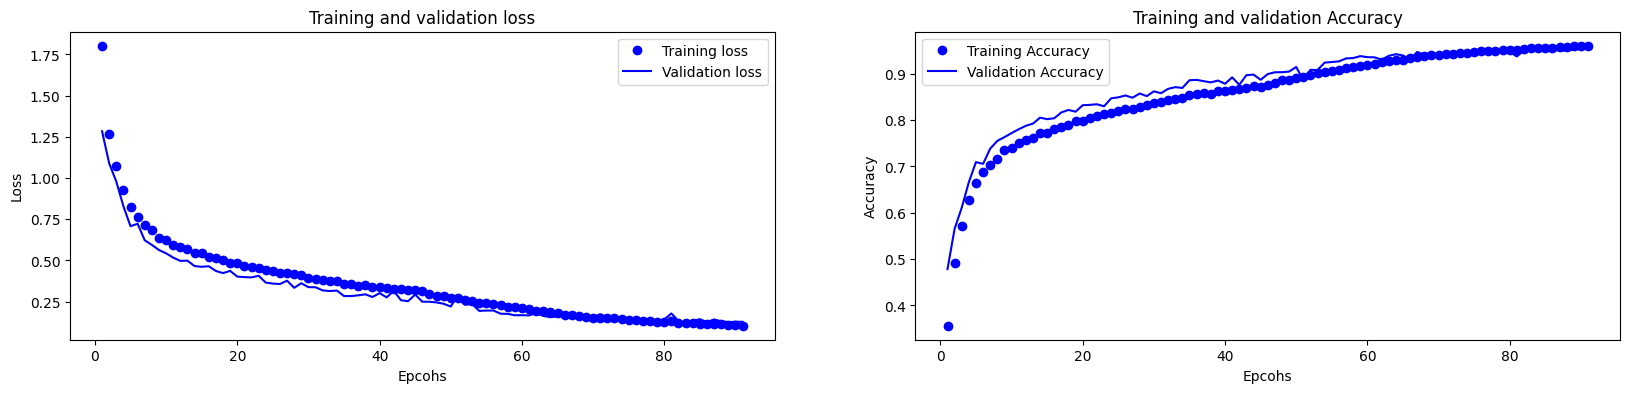

In [ ]:
# Transformer Encoder
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        proj_output = self.dense_proj(proj_output)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

# Transformer Decoder
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        proj_output = self.dense_proj(proj_output)
        return self.layernorm_3(attention_output_2 + proj_output)

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

embed_dim = 256
dense_dim = 512
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="input")
x = PositionalEmbedding(100, 100, embed_dim)(encoder_inputs)
x = layers.Dropout(0.5)(x)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="output")
x = PositionalEmbedding(100, 100, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
x = layers.Dense(100, activation="relu")(x)
decoder_outputs = layers.Dense(100, activation="softmax")(x)
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
transformer.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint("transformer_2.keras",
              monitor="val_loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", 
              mode="min", 
              patience=5)
]
history = transformer.fit(int_train_ds, epochs=100, validation_data=int_val_ds, verbose=0, use_multiprocessing=True, callbacks=callbacks)
model = keras.models.load_model(
    "transformer_2.keras",
    custom_objects={"TransformerDecoder": TransformerDecoder,
                    "TransformerEncoder": TransformerEncoder,
                    "PositionalEmbedding": PositionalEmbedding})
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")
print(accuracy_for_words(model, target_vectorization))
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.legend(loc=2, fontsize=3)
plt.rcParams["figure.figsize"] = (20,4)
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
ax1.plot(epochs, loss_values, "bo", label="Training loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set(xlabel='Epcohs', ylabel='Loss')
ax1.legend()
ax2.plot(epochs, acc, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax2.set_title("Training and validation Accuracy")
ax2.set(xlabel='Epcohs', ylabel='Accuracy')
ax2.legend()
plt.show();

Observations: Adding dropout didn't help with improving word accuracy. Let's increase attention layers to see if it has any effect

16/16 [==============================] - 1s 28ms/step - loss: 0.1798 - accuracy: 0.9360
Test acc: 0.936


(0.5722417215381671, 0.656012530271035)


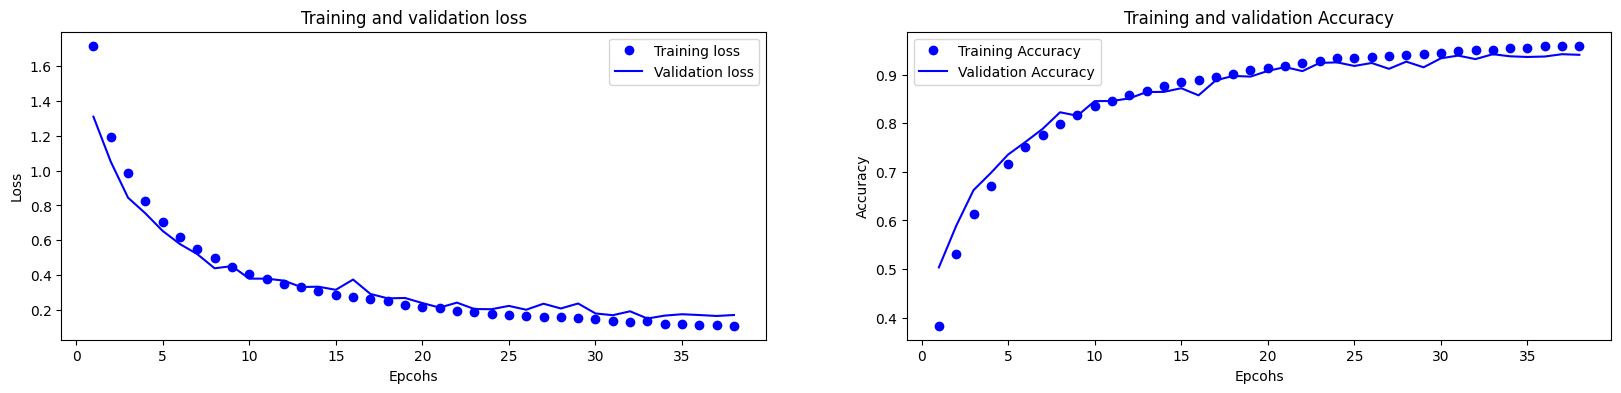

In [ ]:
# Transformer Encoder
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        proj_output = self.dense_proj(proj_output)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

# Transformer Decoder
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_3 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        attention_output_2 = self.layernorm_1(attention_output_1 + attention_output_2)
        attention_output_3 = self.attention_3(
            query=attention_output_2,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_3 = self.layernorm_3(
            attention_output_2 + attention_output_3)
        proj_output = self.dense_proj(attention_output_3)
        proj_output = self.dense_proj(proj_output)
        return self.layernorm_3(attention_output_3 + proj_output)

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

embed_dim = 256
dense_dim = 512
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="input")
x = PositionalEmbedding(100, 100, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="output")
x = PositionalEmbedding(100, 100, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
x = layers.Dense(100, activation="relu")(x)
decoder_outputs = layers.Dense(100, activation="softmax")(x)
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
transformer.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint("transformer_2.keras",
              monitor="val_loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", 
              mode="min", 
              patience=5)
]
history = transformer.fit(int_train_ds, epochs=100, validation_data=int_val_ds, verbose=0, use_multiprocessing=True, callbacks=callbacks)
model = keras.models.load_model(
    "transformer_2.keras",
    custom_objects={"TransformerDecoder": TransformerDecoder,
                    "TransformerEncoder": TransformerEncoder,
                    "PositionalEmbedding": PositionalEmbedding})
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")
print(accuracy_for_words(model, target_vectorization))
fig, (ax1,ax2) = plt.subplots(1, 2)
plt.legend(loc=2, fontsize=3)
plt.rcParams["figure.figsize"] = (20,4)
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
ax1.plot(epochs, loss_values, "bo", label="Training loss")
ax1.plot(epochs, val_loss_values, "b", label="Validation loss")
ax1.set_title("Training and validation loss")
ax1.set(xlabel='Epcohs', ylabel='Loss')
ax1.legend()
ax2.plot(epochs, acc, "bo", label="Training Accuracy")
ax2.plot(epochs, val_acc, "b", label="Validation Accuracy")
ax2.set_title("Training and validation Accuracy")
ax2.set(xlabel='Epcohs', ylabel='Accuracy')
ax2.legend()
plt.show();

Observations: Adding extra attention layers didn't help with improving word accuracy

# Final Model Training
Out of all One-Hot Bigram Model has given the most word accuracy. So, let's train this on entire data

In [ ]:
# Training final Model on all Training Dataset
# Sequence Model - One-Hot Bigram Model
text_pairs = []
for i in range(len(train_in)):
    output = "[start] " + train_out[i] + " [end]"
    text_pairs.append((train_in[i], output))
random.shuffle(text_pairs)
num_train_samples = len(text_pairs)
train_pairs = text_pairs[:num_train_samples]
source_vectorization = layers.TextVectorization(
    max_tokens=100,
    output_sequence_length=100,
    output_mode="int"
)
target_vectorization = layers.TextVectorization(
    max_tokens=100,
    output_sequence_length=101,
    output_mode="int"
)
train_input_texts = [pair[0] for pair in train_pairs]
train_output_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_input_texts)
target_vectorization.adapt(train_output_texts)
# prepare datasets
int_train_ds = make_dataset(train_pairs)
for inputs, targets in int_train_ds.take(1):
    print(f"inputs['input'].shape: {inputs['input'].shape}")
    print(f"inputs['output'].shape: {inputs['output'].shape}")
    print(f"targets.shape: {targets.shape}")

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

inputs = keras.Input(shape=(None,), dtype="int64", name="input")
embedded = tf.one_hot(inputs, depth=100)
x = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(embedded)
x = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(x)
x = layers.Dropout(0.5)(x)
x = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(100, activation="relu")(x)
outputs = layers.Dense(100, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint("633003352_PriyankaReddy_Chukka_P2.keras",
              monitor="loss", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="loss", 
              mode="min", 
              patience=5)
]
history = model.fit(int_train_ds.cache(),
          epochs=100, verbose=0, use_multiprocessing=True,
          callbacks=callbacks)
model = keras.models.load_model("633003352_PriyankaReddy_Chukka_P2.keras")
print('\n Training Accuracy: ', np.mean(history.history['accuracy']))
print('\n Training Loss: ', np.mean(history.history['loss']))
print(accuracy_for_words(model, target_vectorization))

inputs['input'].shape: (16, 100)
inputs['output'].shape: (16, 100)
targets.shape: (16, 100)


Now that final model is trained, going to generate outputs in batches of 500 since anything more than that colab keeps crashing on me

In [ ]:
# Predicting outputs on given test dataset 
def decode_sequence(model, target_vectorization, input_sentence):
    spa_vocab = target_vectorization.get_vocabulary()
    spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
    max_decoded_sentence_length = 100
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])[:, :-1]
        predictions = model.predict({'input':tokenized_input_sentence, 'output':tokenized_target_sentence}, verbose=0)
        sampled_token_index = np.argmax(predictions[0,i,:])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "end":
            break
    return decoded_sentence

def predict_words(model, target_vectorization):
    predicted_words = []
    for pair in text_pairs_in:
        predicted_word = decode_sequence(model, target_vectorization, pair[0]).strip('[start] ').strip(' [end')
        predicted_words.append(predicted_word)       
    return predicted_words

text_pairs_in = []
test_in = pickle.load(open('DS_5_test_input', 'rb')) 
test_in = test_in[4500:5000] 
for i in range(len(test_in)):
    output = "[start] " + train_out[i] + " [end]"
    text_pairs_in.append((test_in[i], output))
model = keras.models.load_model("633003352_PriyankaReddy_Chukka_P2.keras")
pred_output = predict_words(model, target_vectorization)
pickle.dump(pred_output, open('633003352_PriyankaReddy_Chukka_test_out_110','wb'))
files.download('633003352_PriyankaReddy_Chukka_test_out_18')

/usr/local/lib/python3.9/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['output'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Combine all files for output
import glob

file_names = ["633003352_PriyankaReddy_Chukka_test_out_1000","633003352_PriyankaReddy_Chukka_test_out_1000_1500",
              "633003352_PriyankaReddy_Chukka_test_out_1500_2000","633003352_PriyankaReddy_Chukka_test_out_2000_2500",
              "633003352_PriyankaReddy_Chukka_test_out_2500_3000","633003352_PriyankaReddy_Chukka_test_out_3000_3500",
              "633003352_PriyankaReddy_Chukka_test_out_3500_4000","633003352_PriyankaReddy_Chukka_test_out_4000_4500",
              "633003352_PriyankaReddy_Chukka_test_out_4500_5000"]

# List to store the extracted sentences
final_output = []

# Loop through each file and extract the sentences
for file_name in file_names:
    print(file_name)
    file_output = pickle.load(open(file_name, 'rb'))
    for i in range(len(file_output)):
        final_output.append(file_output[i])

# Write the sentences to a file
pickle.dump(final_output, open('633003352_PriyankaReddy_Chukka_P2_output','wb'))
files.download('633003352_PriyankaReddy_Chukka_P2_output')

633003352_PriyankaReddy_Chukka_test_out_1000
633003352_PriyankaReddy_Chukka_test_out_1000_1500
633003352_PriyankaReddy_Chukka_test_out_1500_2000
633003352_PriyankaReddy_Chukka_test_out_2000_2500
633003352_PriyankaReddy_Chukka_test_out_2500_3000
633003352_PriyankaReddy_Chukka_test_out_3000_3500
633003352_PriyankaReddy_Chukka_test_out_3500_4000
633003352_PriyankaReddy_Chukka_test_out_4000_4500
633003352_PriyankaReddy_Chukka_test_out_4500_5000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [61]:
# Verifying different model outputs randomly for my sanity
def decode_sequence(model, target_vectorization, input_sentence):
    spa_vocab = target_vectorization.get_vocabulary()
    spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
    max_decoded_sentence_length = 100
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])[:, :-1]
        predictions = model.predict({'input':tokenized_input_sentence, 'output':tokenized_target_sentence}, verbose=0)
        sampled_token_index = np.argmax(predictions[0,i,:])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "end":
            break
    return decoded_sentence

import nltk

def compute_bleu(reference, candidate):
    return nltk.translate.bleu_score.sentence_bleu([reference], candidate)

def accuracy_for_words(model, target_vectorization):
    cal_accuracy = []
    bleu_score = []
    for pair in text_pairs_in:
        predicted_words = decode_sequence(model, target_vectorization, pair[0]).strip('[start] ').strip(' [end').split()
        ground_truth_words = pair[1].strip('[start] ').strip(' [end').split()
        num_words = len(ground_truth_words)
        accuracy = 0
        for i in range(min(len(predicted_words), len(ground_truth_words))):
            if predicted_words[i] == ground_truth_words[i]:
                accuracy += 1
        accuracy /= num_words
        cal_accuracy.append(accuracy)
        bleu_score.append(compute_bleu(ground_truth_words, predicted_words))
    print(predicted_words)
    print(ground_truth_words)
    cal_accuracy = sum(cal_accuracy) / len(cal_accuracy)
    bleu_score = sum(bleu_score) / len(bleu_score)
    return cal_accuracy, bleu_score

text_pairs_in = []
test_in = pickle.load(open('DS_5_test_input', 'rb')) 
pred_out = pickle.load(open('633003352_PriyankaReddy_Chukka_P2_output', 'rb')) 
random_number = random.randint(0, 5000) # randomly pick a number
print(random_number)
test_in = test_in[random_number:random_number+1]
for i in range(len(test_in)):
    output = "[start] " + pred_out[random_number] + " [end]"
    text_pairs_in.append((test_in[i], output))
model = keras.models.load_model("633003352_PriyankaReddy_Chukka_P2.keras")
print(accuracy_for_words(model, target_vectorization))
# model = keras.models.load_model(
#     "transformer (3).keras",
#     custom_objects={"TransformerDecoder": TransformerDecoder,
#                     "TransformerEncoder": TransformerEncoder,
#                     "PositionalEmbedding": PositionalEmbedding})
# print(accuracy_for_words(model, target_vectorization))
model = keras.models.load_model("one_hot_bidir_lstm.keras")
print(accuracy_for_words(model, target_vectorization))

293
['b', 'f', 'c', 'e', 'c', 'g', 'a', 'i', 'd', 'e', 'f', 'c', 'e', 'c', 'e', 'a', 'e', 'i', 'a', 'd', 'h', 'j', 'a', 'd', 'g', 'k', 'c', 'd', 'b', 'g', 'a', 'j', 'l', 'm', 'ed', 'b', 'd', 'a', 'd', 'ee', 'ef', 'b', 'd', 'c', 'd', 'a', 'd', 'eh', 'ei', 'a', 'g', 'eg', 'ej']
['b', 'f', 'c', 'e', 'c', 'g', 'a', 'i', 'd', 'e', 'f', 'c', 'e', 'c', 'e', 'a', 'e', 'i', 'a', 'd', 'h', 'j', 'a', 'd', 'g', 'k', 'c', 'd', 'b', 'g', 'a', 'j', 'l', 'm', 'ed', 'b', 'd', 'a', 'd', 'ee', 'ef', 'b', 'd', 'c', 'd', 'a', 'd', 'eh', 'ei', 'a', 'g', 'eg', 'ej']
(1.0, 1.0)
['b', 'f', 'c', 'e', 'c', 'g', 'a', 'i', 'd', 'e', 'f', 'c', 'e', 'c', 'e', 'a', 'e', 'i', 'a', 'd', 'h', 'j', 'a', 'k', 'g', 'k', 'c', 'd', 'b', 'g', 'a', 'j', 'l', 'm', 'ed', 'b', 'd', 'a', 'k', 'ee', 'ef', 'b', 'd', 'c', 'd', 'a', 'd', 'eh', 'ei', 'a', 'g', 'eg', 'ej']
['b', 'f', 'c', 'e', 'c', 'g', 'a', 'i', 'd', 'e', 'f', 'c', 'e', 'c', 'e', 'a', 'e', 'i', 'a', 'd', 'h', 'j', 'a', 'd', 'g', 'k', 'c', 'd', 'b', 'g', 'a', 'j', 'l', 

# Testing instructions:
* Please upload DS_5_train_input, DS_5_train_output for source and target vectorization so that model will be able to decode sequences
* Also upload Model 
* Final output is stored in pred_output and also printed -> You can either give list of test_inputs or upload test_file

In [5]:
# For testing
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle
# Upload Training Data for vectorization
from google.colab import files
# files.upload()
train_in = pickle.load(open('DS_5_train_input', 'rb')) 
train_out = pickle.load(open('DS_5_train_output', 'rb')) 
train_pairs = []
for i in range(len(train_in)):
    output = "[start] " + train_out[i] + " [end]"
    train_pairs.append((train_in[i], output))

source_vectorization = layers.TextVectorization(
    max_tokens=100,
    output_sequence_length=100,
    output_mode="int"
)
target_vectorization = layers.TextVectorization(
    max_tokens=100,
    output_sequence_length=101,
    output_mode="int"
)
train_input_texts = [pair[0] for pair in train_pairs]
train_output_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_input_texts)
target_vectorization.adapt(train_output_texts)

def decode_sequence(model, input_sentence):
    print('Input Sentence is: ')
    print(input_sentence)
    spa_vocab = target_vectorization.get_vocabulary()
    spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
    max_decoded_sentence_length = 100
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])[:, :-1]
        predictions = model.predict({'input':tokenized_input_sentence, 'output':tokenized_target_sentence}, verbose=0)
        sampled_token_index = np.argmax(predictions[0,i,:])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "end":
            break
    return decoded_sentence

def predict_words(model):
    predicted_words = []
    for pair in text_pairs_in:
        predicted_word = decode_sequence(model, pair).strip('[start] ').strip(' [end')
        predicted_words.append(predicted_word) 
    print("Predicted output is: ") 
    print(predicted_words)     
    return predicted_words
# Data you want to test on
# test_in = pickle.load(open('DS_5_test_input', 'rb'))  
# text_pairs_in = test_in[0:2]  # give the range of sentences you would want to test
text_pairs_in = ['a g b f a f a e a k a j c f b f c d a k a k c e b g a h a k b d b f b f b d c d'] # can give list of inputs too
model = keras.models.load_model("633003352_PriyankaReddy_Chukka_P2.keras")
pred_output = predict_words(model) # One which gives out pred_output
pickle.dump(pred_output, open('633003352_PriyankaReddy_Chukka_test','wb'))
files.download('633003352_PriyankaReddy_Chukka_test')

Input Sentence is: 
a g b f a f a e a k a j c f b f c d a k a k c e b g a h a k b d b f b f b d c d
Predicted output is: 
['b f c f b f c d a j e f g c e b g a k i j b d b f a k l m b f b d a h ed ee ef a k k eg a k h eh a e ei c d a k ej ek a g d el']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>